<a href="https://colab.research.google.com/github/mrklees/pgmpy/blob/feature%2Fcausalmodel/examples/Causal_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backdoor Paths - Causal Games

This particular notebook walks through the 5 games that used as examples for building intuition about backdoor paths in *The Book of Why* by Judea Peal. They should help to develop some useful intuitions about backdoor paths.

## Objective of the Games

For each game we get a causal graph, and our goal is to identify the set of deconfounders (often denoted $Z$) which will close all backdoor paths from nodes $X$ to $Y$.

In [11]:
!pip install matplotlib
!pip install pgmpy
!pip install daft-pgm

## Game 1

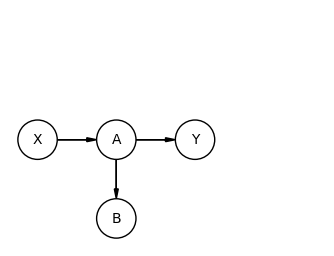

In [12]:
import daft
import matplotlib.pyplot as plt

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference.CausalInference import CausalInference


def convert_pgm_to_pgmpy(pgm):
    """Takes a Daft PGM object and converts it to a pgmpy DiscreteBayesianNetwork"""
    edges = [(edge.node1.name, edge.node2.name) for edge in pgm._edges]
    model = DiscreteBayesianNetwork(edges)
    return model

pgm = daft.PGM(shape=[4, 3])

pgm.add_node(daft.Node("X", r"X", 1, 2))
pgm.add_node(daft.Node("Y", r"Y", 3, 2))
pgm.add_node(daft.Node("A", r"A", 2, 2))
pgm.add_node(daft.Node("B", r"B", 2, 1))


pgm.add_edge("X", "A")
pgm.add_edge("A", "Y")
pgm.add_edge("A", "B")

pgm.render()
plt.show()

While this is a "trivial" example, many statisticians would consider including either or both $A$ and $B$ in their models "just for good measure".  Notice though how controlling for $A$ would close off the path of causal information from $X$ to $Y$, actually *impeding* your effort to measure that effect.

In [13]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


## Game 2

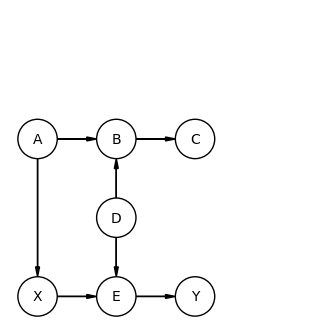

In [15]:
pgm = daft.PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 3))
pgm.add_node(daft.Node("C", r"C", 3, 3))
pgm.add_node(daft.Node("D", r"D", 2, 2))
pgm.add_node(daft.Node("E", r"E", 2, 1))


pgm.add_edge("X", "E")
pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("B", "C")
pgm.add_edge("D", "B")
pgm.add_edge("D", "E")
pgm.add_edge("E", "Y")

pgm.render()
plt.show()

This graph looks harder, but actualy is also trivial to solve.  The key is noticing the one backdoor path, which goes from X <- A -> B <- D -> E -> Y, has a collider at B (or a 'V structure'), and therefore the backdoor path is closed.

In [16]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


## Game 3

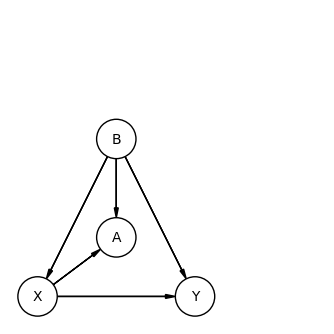

In [17]:
pgm = daft.PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 2, 1.75))
pgm.add_node(daft.Node("B", r"B", 2, 3))


pgm.add_edge("X", "Y")
pgm.add_edge("X", "A")
pgm.add_edge("B", "A")
pgm.add_edge("B", "X")
pgm.add_edge("B", "Y")

pgm.render()
plt.show()

This game actually requires some action.  Notice the backdoor path $X$ <- $B$ -> $Y$.  This is a confounding pattern, is one of the clearest signs that we'll need to control for something, in this case $B$.

In [31]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B'})})


### Game 4

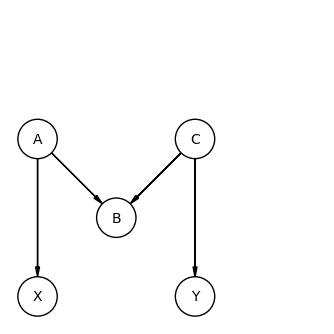

In [18]:
pgm = daft.PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 2))
pgm.add_node(daft.Node("C", r"C", 3, 3))


pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("C", "B")
pgm.add_edge("C", "Y")

pgm.render()
plt.show()

Pearl named this particular configuration "M Bias", not only because of it's shape, but also because of the common practice of statisticians to want to control for $B$ in many situations.  However, notice how in this configuration $X$ and $Y$ start out as *not confounded* and how by controlling for $B$ we would actually introduce confounding by opening the path at the collider, $B$.

In [19]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


### Game 5

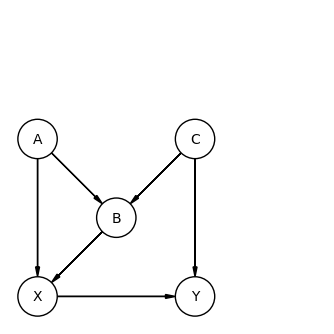

In [20]:
pgm = daft.PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 2, 2))
pgm.add_node(daft.Node("C", r"C", 3, 3))


pgm.add_edge("A", "X")
pgm.add_edge("A", "B")
pgm.add_edge("C", "B")
pgm.add_edge("C", "Y")
pgm.add_edge("X", "Y")
pgm.add_edge("B", "X")

pgm.render()
plt.show()

This is the last game in The Book of Why is the most complex.  In this case we have two backdoor paths, one going through $A$ and the other through $B$, and it's important to notice that if we only control for $B$ that the path: $X$ <- $A$ -> $B$ <- $C$ -> $Y$ (which starts out as closed because $B$ is a collider) actually is opened.  Therefore we have to either close both $A$ and $B$ or, as astute observers will notice, we can also just close $C$ and completely close both backdoor paths.  pgmpy will nicely confirm these results for us.

In [35]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'C'}), frozenset({'A', 'B'})})


## Game 6

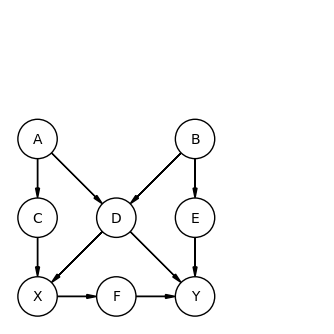

In [21]:
pgm = daft.PGM(shape=[4, 4])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 1, 3))
pgm.add_node(daft.Node("B", r"B", 3, 3))
pgm.add_node(daft.Node("C", r"C", 1, 2))
pgm.add_node(daft.Node("D", r"D", 2, 2))
pgm.add_node(daft.Node("E", r"E", 3, 2))
pgm.add_node(daft.Node("F", r"F", 2, 1))


pgm.add_edge("X", "F")
pgm.add_edge("F", "Y")
pgm.add_edge("C", "X")
pgm.add_edge("A", "C")
pgm.add_edge("A", "D")
pgm.add_edge("D", "X")
pgm.add_edge("D", "Y")
pgm.add_edge("B", "D")
pgm.add_edge("B", "E")
pgm.add_edge("E", "Y")

pgm.render()
plt.show()

So these are no longer drawn from The Book of Why, but were either drawn from another source (which I will reference) or a developed to try to induce a specific bug. his example is drawn from Causality by Pearl on p. 80. This example is kind of interesting because there are many possible combinations of nodes which will close the two backdoor paths which exist in this graph.  In turns out that $D$ plus any other node in $\{A, B, C, E\}$ will deconfound $X$ and $Y$.


In [22]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
bd_adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {bd_adj_sets}")
fd_adj_sets = inference.get_all_frontdoor_adjustment_sets("X", "Y")
print(f"Ehat's the possible front adjustment sets? {fd_adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'C', 'D'}), frozenset({'A', 'D'}), frozenset({'B', 'D'}), frozenset({'E', 'D'})})
Ehat's the possible front adjustment sets? frozenset({frozenset({'F'})})


## Game 7

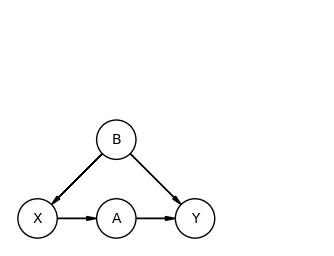

In [24]:
pgm = daft.PGM(shape=[4, 3])

pgm.add_node(daft.Node("X", r"X", 1, 1))
pgm.add_node(daft.Node("Y", r"Y", 3, 1))
pgm.add_node(daft.Node("A", r"A", 2, 1))
pgm.add_node(daft.Node("B", r"B", 2, 2))


pgm.add_edge("X", "A")
pgm.add_edge("A", "Y")
pgm.add_edge("B", "X")
pgm.add_edge("B", "Y")

pgm.render()
plt.show()

This game tests the front door adjustment.  $B$ is taken to be unobserved, and therfore we cannot close the backdoor path $X$ <- $B$ -> $Y$.

In [25]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(
    f"Are there are active backdoor paths? {not inference.is_valid_backdoor_adjustment_set('X', 'Y')}"
)
bd_adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {bd_adj_sets}")
fd_adj_sets = inference.get_all_frontdoor_adjustment_sets("X", "Y")
print(f"Ehat's the possible front adjustment sets? {fd_adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B'})})
Ehat's the possible front adjustment sets? frozenset({frozenset({'A'})})
